In [ ]:
#This script is used by Brouwer et al. to analyse MNase-seq data. Starting point are bam files with mapped reads.

In [112]:
import mnase_analysis_functions2 as maf
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [4]:
###FILTER FOR LENGTH 95-225 BP AND WRITE NEW BAMFILE

#setting datapath (where bam files with mapped reads are stored)
bamDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/mapped_to_ref_bams/'

#setting path to write filtered bam files
outDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/filtered_95-225bp/'
maf.filterLengthDir(bamDir,outDir,95,225)

#indexing filtered bamfiles
maf.indexBamDir(outDir)

  0%|          | 0/8 [00:00<?, ?it/s]

AttributeError: 'module' object has no attribute 'indexBamDir'

In [8]:
##CALCULATE COVERAGE OF FILTERED BAMFILES AND WRITE TO JSON FILE

#setting paths, getting list of bamfiles
bamDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/filtered_95-225bp/'
bamList = maf.getBamList(bamDir)

In [13]:
#run idxstats on bamfiles
maf.idxstatsList(bamList,bamDir)

#extract coverage and write to txt file
outDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/filtered_95-225bp_coverage/'
maf.extractCoverageListNormCovChr(bamList,bamDir,outDir)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [18]:
#get name and length of chromosomes from first bam file. Assumes that this is the same for all files in the dataset.
inPath = bamDir+bamList[0]
chromcontigs = maf.getChromcontigs(inPath)
chromLengths = maf.getChromLengths(inPath, chromcontigs)

In [23]:
##BUILDING GENEINFO

#Getting geneInfo from excel file downloaded from SGD and included in this git repository. Reference:
# Cherry, J.M., Hong, E.L., Amundsen, C., Balakrishnan, R., Binkley, G., Chan, E.T., Christie, K.R., Costanzo, M.C., 
# Dwight, S.S., Engel, S.R., et al. (2012). Saccharomyces Genome Database: The genomics resource of budding yeast. 
# Nucleic Acids Res. 40, 700–705.
geneFilePath = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/SGD_features.xls'
geneInfo = maf.buildGeneInfo(geneFilePath,chromcontigs,chromLengths)

#Adding info on TATA and TATAmismatch locations, based on excel file included in this git repository. Reference:
# Rhee, H.S., and Pugh, B.F. (2012). Genome-wide structure and organization of eukaryotic pre-initiation complexes. 
# Nature 483, 295–301.
TATAFilePath = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/Rhee_Pugh_2012.xls'
geneInfo = maf.addTATAInfo(TATAFilePath,geneInfo)

In [24]:
###CALCULATING COVERAGE PER GENE IN EACH BAMFILE

In [25]:
#this function needs to be adapted to the dataset, to extract metadata from the filename
def parseFilename(filename):
    metaDict = {}
    splitfile = filename.split('_')
    strainRep = splitfile[2]
    if strainRep[-1] == '2':
        strain = strainRep[:-2]
        rep = strainRep[-2:]
    else: 
        strain = strainRep[:-4]
        rep = strainRep[-4:]
    metaDict['filename'] = filename
    metaDict['strain'] = strain
    metaDict['factorDepl'] = factorDeplPerStrain[strain]
    metaDict['rep'] = rep
    metaDict['sugar'] = splitfile[3]
    rapa = splitfile[4]
    metaDict['rapa'] = rapa
    metaDict['plotCol'] = plotColPerRapa[rapa]
    metaDict['rapaCond'] = rapaCondPerRapa[rapa]
    mnase = splitfile[6]
    metaDict['mnase'] = mnase
    metaDict['mnaseCond'] = mnasePerVal[mnase]
    metaDict['lineStyle'] = lineStylePerRep[rep]
    return metaDict

In [26]:
#this needs to be adapted to the dataset
factorDeplPerStrain = {'YTL1584': 'Sth1&50%TBP'}
mnasePerVal = {'1': 'low','3':'high'}
plotColPerRapa = {'rapa': 'red','-rapa': 'grey'}
rapaCondPerRapa = {'rapa': 'Rapamycin','-rapa': 'DMSO'}
lineStylePerRep = {'A1-1':'--','B2':'-'}

In [53]:
#calculate coverage around each gene, store in a list over the bam files
covDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/filtered_95-225bp_coverage/'
geneCovPerBam = []
for filename in tqdm(bamList):
    covPath = covDir+filename.split('.bam')[0]+'_chromosome_coverages.txt'
    geneCovPerBam.append({'metadata':parseFilename(filename),
                          'geneInfoDictBam':maf.calcCovBam(covPath,geneInfo,chromLengths)})

  0%|          | 0/8 [00:00<?, ?it/s]

In [55]:
###CALCULATING COVERAGE ALIGNED AT PLUS ONE OF WT

In [70]:
def selectAlignedCovs(alignedCovs,mnaseCond,factorDepl,sugar,alignment):
    selected = []
    for alignedCov in alignedCovs:
        metadata = alignedCov['metadata']
        if metadata['mnaseCond'] != mnaseCond: continue
        if metadata['factorDepl'] != factorDepl: continue
        if metadata['alignment'] != alignment: continue
        if metadata['sugar'] != sugar: continue
        selected.append(alignedCov) 
    return selected

In [58]:
def plotCov(selectedAlignedCovs,showFig,saveFig,outDir):
    xVals = range(-1000,1000)
    fig = plt.figure()
    factorDepl = selectedAlignedCovs[0]['metadata']['factorDepl']
    alignment = selectedAlignedCovs[0]['metadata']['alignment']
    mnaseCond = selectedAlignedCovs[0]['metadata']['mnaseCond']
    sugar = selectedAlignedCovs[0]['metadata']['sugar']
    for alignedCov in selectedAlignedCovs:
        cov = alignedCov['covAligned']
        metadata = alignedCov['metadata']
        legendTxt = 'Rep '+metadata['rep']+' in '+metadata['rapaCond']
        plt.plot(xVals,cov,color = metadata['plotCol'],lineStyle = metadata['lineStyle'], label = legendTxt)
    plt.title('Coverage around '+alignment+' +/- '+factorDepl+' in '+sugar+' with '+mnaseCond+' MNase')
    plt.xlabel('distance from '+alignment+' (bp)')
    plt.ylabel('Coverage')
    plt.legend()
    plt.xlim(-1000,1000)
    plt.axvline(0,linestyle = '--')
    if showFig: plt.show()
    if saveFig: fig.savefig(outDir+'coverage_around_'+alignment+'_'+factorDepl+'_'+sugar+'_'+mnaseCond+'_mnase.pdf',
                            bbox_inches='tight')
    plt.close()

In [62]:
#setting path and importing list of +1 positions per gene, based on MNase_finding_NDR_parameters.ipynb.
#this should be calculated for each control condition, for example media sugar conditions.
pathPlusOneGal = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/NDRprops_DMSO_AA_data_all_GAL.json'
plusOneGal = maf.importNDRprops(pathPlusOneGal)

In [65]:
#for each dataset, calculate the metagene coverage (average of all genes) aligned at the position of the +1 nucleosome
for geneCov in tqdm(geneCovPerBam):
    outFileName = geneCov['metadata']['filename'].split('.bam')[0]+'_coverage_aligned_plusOneControl.json'
    outPath = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/aligned_coverages/'+outFileName 
    maf.calcCovPlusOneControlAligned(geneCov,plusOneGal,outPath)

  0%|          | 0/8 [00:00<?, ?it/s]

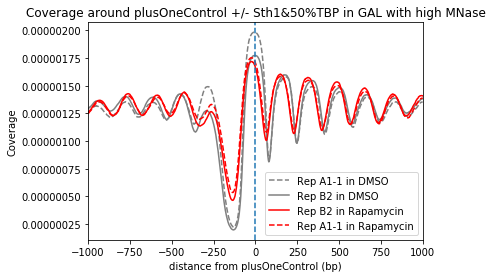

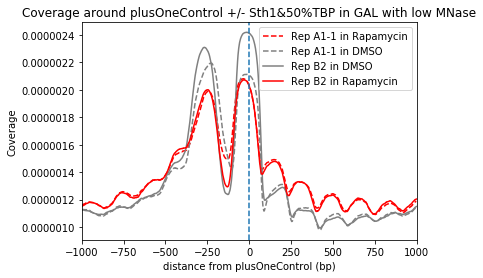

In [71]:
#import aligned coverages calculated above, select those with high and those with low MNase treatment.
inDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/aligned_coverages/'
alignedCovs = maf.importAlignedCovs(inDir)
alignedPlusOneControlCovsHigh = selectAlignedCovs(alignedCovs,'high','Sth1&50%TBP','GAL','plusOneControl')
alignedPlusOneControlCovsLow = selectAlignedCovs(alignedCovs,'low','Sth1&50%TBP','GAL','plusOneControl')
expList = [alignedPlusOneControlCovsHigh,alignedPlusOneControlCovsLow]

#plot metagene plots for high and low MNase seperately. Show and save plots to file.
showFig = True
saveFig = True
outDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/plots_aligned_coverages/'
for selectedAlignedCovs in expList:
    plotCov(selectedAlignedCovs,showFig,saveFig,outDir)

In [80]:
### CUMULATIVE DISTRIBUTIONS OF COVERAGE IN TATA AND TATA-MISMATCH REGIONS

In [81]:
#calculate coverage at different genomic festures, including TATA and TATA-mismatch regions
covFeatures = maf.extractCovFeatures(geneCovPerBam)

  0%|          | 0/8 [00:00<?, ?it/s]

In [87]:
#calculate cumulative distributions of coverage in TATA and TATA-mismatch
outDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/coverage_genomic_features_cumulative/'
maf.writeCumDistribution(covFeatures,'TATAmisCovs',outDir)
maf.writeCumDistribution(covFeatures,'TATACovs',outDir)

In [88]:
#import all cumulative distributions of coverage in TATA and TATA-mismatch
inDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/coverage_genomic_features_cumulative/'
allCovFeaturesCum = maf.importCovFeatures(inDir)

In [89]:
#function to select relevant cumulative distributions
def selectCovFeatures(covFeatures, factorDepl, sugar, mnaseCond, covFeature):
    selected = []
    for element in covFeatures:
        if element['metadata']['factorDepl'] != factorDepl: continue
        if element['metadata']['sugar'] != sugar: continue
        if element['metadata']['mnaseCond'] != mnaseCond: continue
        if element['metadata']['covFeature'] != covFeature: continue
        selected.append(element)
    return selected

In [90]:
#select cumulative distributions of coverages based on MNase digestion
covFeatHighTATAmisCovsCum = selectCovFeatures(allCovFeaturesCum, 'Sth1&50%TBP', 'GAL', 'high', 'TATAmisCovs')
covFeatLowTATAmisCovsCum = selectCovFeatures(allCovFeaturesCum, 'Sth1&50%TBP', 'GAL', 'low', 'TATAmisCovs')

covFeatHighTATACovsCum = selectCovFeatures(allCovFeaturesCum, 'Sth1&50%TBP', 'GAL', 'high', 'TATACovs')
covFeatLowTATACovsCum = selectCovFeatures(allCovFeaturesCum, 'Sth1&50%TBP', 'GAL', 'low', 'TATACovs')

In [92]:
#function to plot cumulative distributions
def plotCumCov(selCovFeaturesCum,maxX,showFig,saveFig,outDir):
    factorDepl = selCovFeaturesCum[0]['metadata']['factorDepl']
    sugar = selCovFeaturesCum[0]['metadata']['sugar']
    mnaseCond = selCovFeaturesCum[0]['metadata']['mnaseCond']
    covGenRegion = selCovFeaturesCum[0]['metadata']['covFeature']
    
    if covGenRegion == 'TATACovs':
        titletxt = 'Cumulative coverage in TATA-box +/- '+factorDepl+' using '+mnaseCond+' MNase'
        xlabeltxt = 'Coverage'
    elif covGenRegion == 'TATAmisCovs':
        titletxt = 'Cumulative coverage in TATA-mismatch +/- '+factorDepl+' using '+mnaseCond+' MNase'
        xlabeltxt = 'Coverage'
    
    fig = plt.figure()
    maxVal = 0
    for element in selCovFeaturesCum:
        metadata = element['metadata']
        cumDistr = element['cumDistr']
        thisMax = np.max(cumDistr[0])
        if thisMax > maxVal: 
            maxVal = thisMax
        legendTxt = metadata['strain']+'-'+metadata['rep']+' in '+metadata['sugar']
        plt.plot(cumDistr[0],cumDistr[1],
                 color = metadata['plotCol'],linestyle = metadata['lineStyle'], label = legendTxt)
    
    mnaseCond = selCovFeaturesCum[0]['metadata']['mnaseCond']
    plt.title(titletxt+' with '+mnaseCond+' MNase')
    plt.xlabel(xlabeltxt)
    plt.ylabel('Frequency')
    if maxX == None:
        plt.xlim(0,maxVal)
    else:
        plt.xlim(0,maxX)
    plt.ylim(0,1)
    plt.legend()
    if showFig: plt.show()
    if saveFig: fig.savefig(outDir+'cumulative_'+covGenRegion+'_'+factorDepl+'_'+sugar+'_'+mnaseCond+'_mnase.pdf',
                            bbox_inches='tight')
    plt.close()

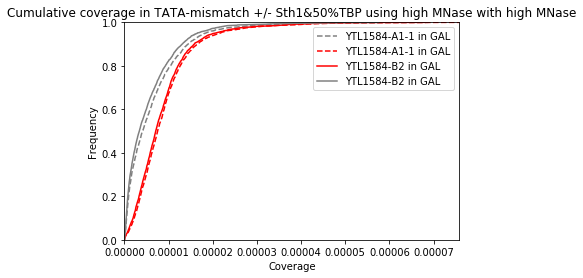

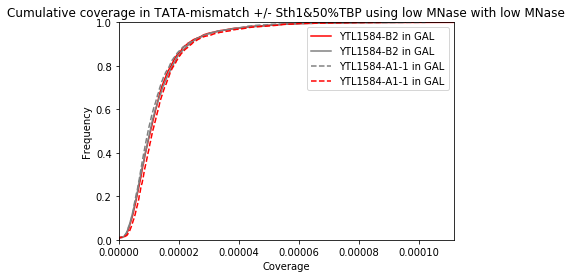

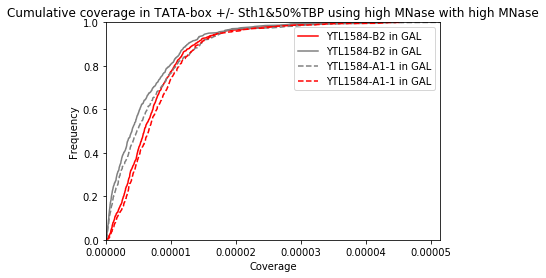

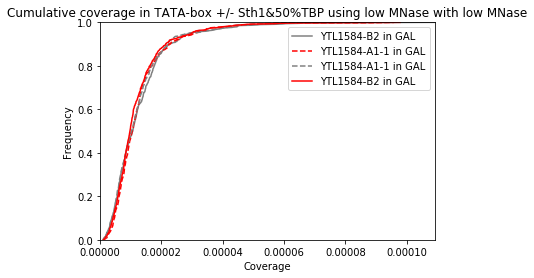

In [97]:
#plot and save figure of cumulative distribution
outDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/plots_coverage_genomic_features_cumulative/'
showFig = True
saveFig = True
maxX = None

plotCumCov(covFeatHighTATAmisCovsCum,maxX,showFig,saveFig,outDir)
plotCumCov(covFeatLowTATAmisCovsCum,maxX,showFig,saveFig,outDir)
plotCumCov(covFeatHighTATACovsCum,maxX,showFig,saveFig,outDir)
plotCumCov(covFeatLowTATACovsCum,maxX,showFig,saveFig,outDir)

In [101]:
##HEATMAPS OF COVERAGE; ALIGNED AT +1 OF WT SAMPLE, SORTED BY NDR WIDTH

In [102]:
#sort list of gene names by NDR width (width determined based on all control datasets)
sortedGeneNamesGal = maf.sortByNDR(plusOneGal)

In [108]:
#for each dataset, calculate heatmap in which the nucleosome density along all genes is plotted
#rows are sorted by NDR width
#coverage is aligned at the +1 nucleosome in control conditions.
#warning: cannot show and save figure at the same time
showFig = False
saveFig = True

for geneCov in tqdm(geneCovPerBam):
    metadata = geneCov['metadata']
    alignmentMethod = 'plusOneWT'
    filename = metadata['filename'].split('.bam')[0]+'_heatmap_aligned_'+alignmentMethod+'_sorted_NDRwidthWT'
    pathMat = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/heatmaps_matrices/aligned_plusOneWT_sorted_NDRwidthWT/'+filename+'.npy'        
    maf.calcHeatmapMatrix(geneCov, alignmentMethod, plusOneGal, sortedGeneNamesGal,pathMat)
    xLabelTxt = 'Aligned at +1 nucleosome of high MNase, '+metadata['sugar']+' sample, sorted by NDR width of WT high MNase, '+metadata['sugar']+' sample'
    titleTxt = metadata['factorDepl']+' rep '+metadata['rep']+' in '+metadata['rapaCond']+' in '+metadata['sugar']+' using '+metadata['mnaseCond']+' MNase'
    outPathFig = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/plots_heatmaps/aligned_plusOneWT_sorted_NDRwidthWT/'+filename+'.png'
    maf.plotHeatmap(pathMat,0.00002,xLabelTxt,titleTxt,showFig,saveFig,outPathFig)
    

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5147 [00:00<?, ?it/s]

  0%|          | 0/5147 [00:00<?, ?it/s]

  0%|          | 0/5147 [00:00<?, ?it/s]

  0%|          | 0/5147 [00:00<?, ?it/s]

  0%|          | 0/5147 [00:00<?, ?it/s]

  0%|          | 0/5147 [00:00<?, ?it/s]

  0%|          | 0/5147 [00:00<?, ?it/s]

  0%|          | 0/5147 [00:00<?, ?it/s]

In [109]:
##HEATMAPS OF LOG2FOLDCHANGE WRT WT

In [110]:
#function to select heatmaps calculated above based on depleted factor, sugar, rapamycin condition and MNase
def selectHeatMaps(pathMat,factorDepl,sugar,mnaseCond,rapaCond):
    selectedHeatmaps = []

    filelist = os.listdir(pathMat)

    for filename in filelist:
        if len(filename.split('.')[0]) == 0: continue
        heatMap = np.load(pathMat+filename,allow_pickle=True)
        if heatMap[2]['factorDepl'] != factorDepl: continue
        if heatMap[2]['sugar'] != sugar: continue
        if heatMap[2]['mnaseCond'] != mnaseCond: continue
        if heatMap[2]['rapaCond'] != rapaCond: continue
        selectedHeatmaps.append(heatMap)
    return selectedHeatmaps   

In [113]:
#select all control (DMSO) heatmaps in high and low MNase concentration
pathMat = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/heatmaps_matrices/aligned_plusOneWT_sorted_NDRwidthWT/'
heatMapsCntrlHigh = selectHeatMaps(pathMat,'Sth1&50%TBP','GAL','high','DMSO')
heatMapsCntrlLow = selectHeatMaps(pathMat,'Sth1&50%TBP','GAL','low','DMSO')


In [114]:
#set path to store matrices and plots of average heatmap of control conditions
matDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/heatmaps_matrices/combined_aligned_plusOne_sorted_NDRwidth/'
outDirFig = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/plots_heatmaps/combined_aligned_plusOne_sorted_NDRwidth/'

#set x-axis label of heatmaps
xLabelTxt = 'Aligned at +1 nucleosome of GAL high MNase sample, sorted by NDR width of GAL high MNase sample'

#warning: cannot show and save heatmaps at the same time
showFig = False
saveFig = True

#For average heatmap in high MNase condition, set filename, calculate average heatmap and plot or save heatmap
matFilename = 'combined_heatmap_DMSO_Sth1&50%TBP_Gal_high.npy'
avgHeatMapCntrlHigh = maf.combineReps(heatMapsCntrlHigh,sortedGeneNamesGal,matDir+matFilename)
titleTxt = 'Average heatmap in DMSO in GAL using high MNase'
filenameFig = 'average_heatmap_DMSO_Sth1&50%TBP_GAL_high_mnase.png'
maf.plotHeatmap(matDir+matFilename, 0.00002, xLabelTxt, titleTxt, showFig, saveFig, outDirFig+filenameFig)

#For average heatmap in low MNase condition, set filename, calculate average heatmap and plot or save heatmap
matFilename = 'combined_heatmap_DMSO_Sth1&50%TBP_Gal_low.npy'
avgHeatMapCntrlLow = maf.combineReps(heatMapsCntrlLow,sortedGeneNamesGal,matDir+matFilename)
titleTxt = 'Average heatmap in DMSO in GAL using low MNase'
filenameFig = 'average_heatmap_DMSO_Sth1&50%TBP_GAL_low_mnase.png'
maf.plotHeatmap(matDir+matFilename, 0.00002, xLabelTxt, titleTxt, showFig, saveFig, outDirFig+filenameFig)

In [115]:
#function to select average heatmap
def selectAvgHeatMaps(pathMat,factorDepl,sugar,mnaseCond):
    selectedHeatmaps = []

    filelist = os.listdir(pathMat)

    for filename in filelist:
        if len(filename.split('.')[0]) == 0: continue
        heatMap = np.load(pathMat+filename,allow_pickle=True)
        if heatMap[2]['factorDepl'] != factorDepl: continue
        if heatMap[2]['sugar'] != sugar: continue
        if heatMap[2]['mnaseCond'] != mnaseCond: continue
        selectedHeatmaps.append(heatMap)
        
    return selectedHeatmaps   

In [116]:
#select and import average heatmap for high and low MNase in control (DMSO)
inDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/heatmaps_matrices/combined_aligned_plusOne_sorted_NDRwidth/'
AvgHeatMapCntrlHigh = selectAvgHeatMaps(inDir,'Sth1&50%TBP','GAL','high')
AvgHeatMapCntrlLow = selectAvgHeatMaps(inDir,'Sth1&50%TBP','GAL','low')


In [117]:
#select and import all heatmaps of individual datasets
heatMapsHigh = selectHeatMaps(pathMat,'Sth1&50%TBP','GAL','high','DMSO')+selectHeatMaps(pathMat,'Sth1&50%TBP','GAL','high','Rapamycin')
heatMapsLow = selectHeatMaps(pathMat,'Sth1&50%TBP','GAL','low','DMSO')+selectHeatMaps(pathMat,'Sth1&50%TBP','GAL','low','Rapamycin')


In [121]:
#warning: cannot show and save heatmap figure at the same tim
showFig = False
saveFig = True

#set minimum and maximum value for colormap of log2-fold-change heatmaps
vMin = -5
vMax = 5

#set x-axis label for log2-fold-change heatmaps
xLabelTxt = 'Aligned at +1 nucleosome of high MNase sample, sorted by NDR width of high MNase sample'

#for each heatmap in high MNase condition, calculate and plot log2-fold-change with respect to average heatmap in 
#control (DMSO) setting. Before calculating log2-fold-change, make sure heatmaps include the same genes. Exclude 
#genes that don't appear in both heatmaps, to make the matrices the same dimensions.
for heatMap in tqdm(heatMapsHigh):
    metadata = heatMap[2]
    resizedHeatMaps = maf.resizeHeatmaps(heatMap,AvgHeatMapCntrlHigh[0])
    pathMat = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/heatmaps_matrices/log2fc_wrt_WT/'
    filename = metadata['filename'].split('.bam')[0]+'_log2fc_heatmap_aligned_plusOneWT_sorted_NDRWidthWT.npy'
    maf.calcHeatMapLog2FoldChange(resizedHeatMaps[0],resizedHeatMaps[1],pathMat+filename)    
    titleTxt = metadata['factorDepl']+' rep '+metadata['rep']+' in '+metadata['rapaCond']+' in '+metadata['sugar']+' using '+metadata['mnaseCond']+' MNase'
    figPath = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/plots_heatmaps/log2fc_wrt_WT/'
    figFilename = filename.split('.npy')[0]+'.png'
    maf.plotHeatmapChange(pathMat+filename, vMax, vMin, xLabelTxt, titleTxt, showFig, saveFig, figPath+figFilename)

#same for low MNase condition
for heatMap in tqdm(heatMapsLow):
    metadata = heatMap[2]
    resizedHeatMaps = maf.resizeHeatmaps(heatMap,AvgHeatMapCntrlLow[0])
    pathMat = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/heatmaps_matrices/log2fc_wrt_WT/'
    filename = metadata['filename'].split('.bam')[0]+'_log2fc_heatmap_aligned_plusOneWT_sorted_NDRWidthWT.npy'
    maf.calcHeatMapLog2FoldChange(resizedHeatMaps[0],resizedHeatMaps[1],pathMat+filename)    
    titleTxt = metadata['factorDepl']+' rep '+metadata['rep']+' in '+metadata['rapaCond']+' in '+metadata['sugar']+' using '+metadata['mnaseCond']+' MNase'
    figPath = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/plots_heatmaps/log2fc_wrt_WT/'
    figFilename = filename.split('.npy')[0]+'.png'
    maf.plotHeatmapChange(pathMat+filename, vMax, vMin, xLabelTxt, titleTxt, showFig, saveFig, figPath+figFilename)    


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [122]:
##HISTOGRAM OF CHANGE IN +1

In [123]:
#function to select data from control bams
def selectGeneCovControlBams(geneCovPerBam,mnaseCond,factorDepl,sugar):
    selected = []
    for geneCov in geneCovPerBam:
        if geneCov['metadata']['rapaCond'] != 'DMSO': continue
        if geneCov['metadata']['mnaseCond'] != mnaseCond: continue
        if geneCov['metadata']['sugar'] != sugar: continue 
        if geneCov['metadata']['factorDepl'] != factorDepl: continue
        selected.append(geneCov) 
    return selected

In [124]:
#calculate change in +1 position in each dataset
outDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/change_plusOne/'

for geneCov in tqdm(geneCovPerBam):
    metadata = geneCov['metadata']
    factorDepl = metadata['factorDepl']
    sugar = metadata['sugar']
    mnaseCond = metadata['mnaseCond']
    filename = metadata['filename']
    outPath = outDir + filename.split('.bam')[0]+'change_plusOne.npy'
    if mnaseCond == 'high':
        plusOneList = plusOneGal
    if mnaseCond == 'low':
        plusOneList = plusOneGal     

    maf.calcChangePlusOne(geneCov,plusOneList,outPath)

  0%|          | 0/8 [00:00<?, ?it/s]

In [125]:
#function to select data on change in +1 position
def selectChangePlusOne(inDir,factorDepl,sugar,mnaseCond):
    selectedDatasets = []

    filelist = os.listdir(inDir)

    for filename in filelist:
        if len(filename.split('.')[0]) == 0: continue
        data = np.load(inDir+filename,allow_pickle=True)[0]
        metadata = data['metadata']
        if metadata['factorDepl'] != factorDepl: continue
        if metadata['sugar'] != sugar: continue
        if metadata['mnaseCond'] != mnaseCond: continue

        selectedDatasets.append(data)
        
    return selectedDatasets 

In [126]:
#function to plot change in +1 position
def plotHistChangePlusOne(selDatasets,binWidth,showFig,saveFig,outDir):
    
    factorDepl = selDatasets[0]['metadata']['factorDepl']
    mnaseCond = selDatasets[0]['metadata']['mnaseCond']
    sugar = selDatasets[0]['metadata']['sugar']
    
    for key in ['outputAll']:
        fig = plt.figure()
        for dataset in selDatasets:
            output = dataset[key]
            histData = maf.calcHistNeg(binWidth,output)

            metadata = dataset['metadata']
            if metadata['rapaCond'] != 'Rapamycin': continue
            plotCol = metadata['plotCol']
            lineStyle = metadata['lineStyle']

            legendTxt = 'Rep '+metadata['rep']+' in '+metadata['rapaCond']
            plt.plot(histData[1],histData[0],
                     color = plotCol,linestyle = lineStyle, label = legendTxt)

        if key == 'outputAll': 
            titlepart = 'All genes'
            filenamePart = 'all_genes_'
                
        plt.xlabel('Shift in +1 position (bp)')
        plt.ylabel('Frequency')
        plt.title(titlepart+' +/- '+factorDepl+' using '+mnaseCond+' MNase')
        plt.legend()
        plt.xlim(-100,100)
        if showFig: plt.show()
        if saveFig: fig.savefig(outDir+'histogram_changePlusOne_'+filenamePart+factorDepl+'_in_'+mnaseCond+'_mnase.pdf',bbox_inches='tight')
        plt.close()


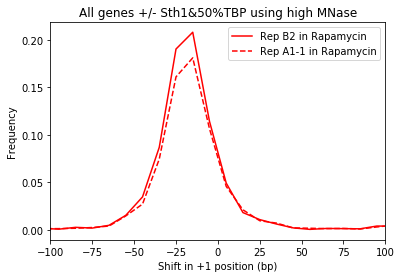

In [129]:
#plot and save histogram of change in +1 position with indicated binwidth
inDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/change_plusOne/'
showFig = True
saveFig = True
outDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/plots_change_plusOne/'
binWidth = 10

factorDepl = 'Sth1&50%TBP'
for mnaseCond in ['high']:
    selDatasets = selectChangePlusOne(inDir,factorDepl,sugar,mnaseCond)
    plotHistChangePlusOne(selDatasets,binWidth,showFig,saveFig,outDir)

In [130]:
##PLOTS OF COVERAGE AROUND GAL10

In [131]:
#function to select coverage data
def selectGeneCovs(allGeneCovs,geneName,factorDepl,mnaseCond,sugar):
    selected = []
    for geneCov in allGeneCovs:
        if geneCov['metadata']['mnaseCond'] != mnaseCond: continue
        if geneCov['metadata']['geneName'] != geneName: continue
        if geneCov['metadata']['factorDepl'] != factorDepl: continue
        if geneCov['metadata']['sugar'] != sugar: continue
        selected.append(geneCov)
    return selected

In [132]:
#function to plot coverage around an individual gene
def plotCovGene(selectedGeneCovs,showFig,saveFig,outDir):
    xVals = range(-1000,1000)
    fig,ax = plt.subplots()
    
    for geneCov in selectedGeneCovs:
        metadata = geneCov['metadata']
        coverage = geneCov['coverage']
        TATAGalStart = geneCov['TATAGalStart']
        gal4UASs = geneCov['gal4UASs']
        geneName = metadata['geneName']
        factorDepl = metadata['factorDepl']
        sugar = metadata['sugar']
        
        mnaseCond = metadata['mnaseCond']
        legendTxt = metadata['factorDepl']+' rep '+metadata['rep']+' in '+metadata['rapaCond']
        plt.plot(xVals,coverage,color = metadata['plotCol'],
                     label = legendTxt, linestyle = metadata['lineStyle'])
        ax.axvspan(TATAGalStart,TATAGalStart+8,alpha = 0.2, color = 'blue',ec=None)
        for gal4UAS in gal4UASs:
            ax.axvspan(gal4UAS, gal4UAS+17, alpha=0.2, color='green',ec=None)
    
    plt.title('Coverage around '+geneName+' TSS in +/- '+factorDepl+' in '+sugar+' using '+mnaseCond+' MNase')
    plt.xlabel('distance from TSS (bp)')
    plt.ylabel('Coverage')
    plt.legend()
    plt.xlim(-1000,1000)
    plt.axvline(0,linestyle = '--')
    if showFig: plt.show()
    if saveFig: fig.savefig(outDir+'coverage_around_'+geneName+'_TSS_'+factorDepl+'_'+sugar+'_'+mnaseCond+'_mnase.pdf',bbox_inches='tight')
    plt.close() 

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

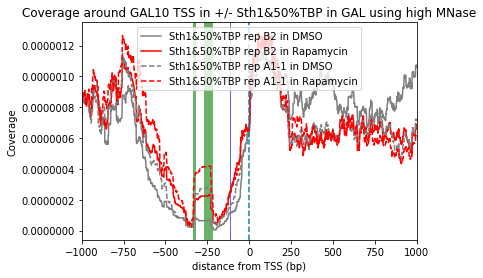

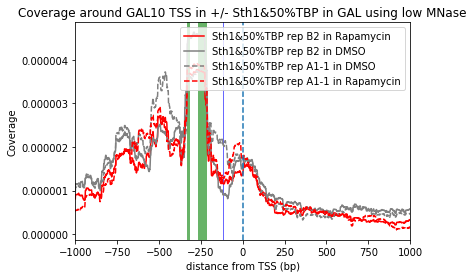

In [141]:
#selecting info on GAL10 from geneInfo
listGalGeneNames = ['GAL10']
geneInfoGAL = maf.selectGenes(geneInfo,listGalGeneNames)

#adding gal4 bs locations to geneInfo, based on excel file included in this git repository.
gal4Path = '/DATA/lenstra_lab/in.brouwer/MNAse/20200327_Gal4_UASs/Gal4_BS_locations.xls'
geneInfoGAL = maf.addGal4Info(gal4Path,geneInfoGAL)

#adding TATA locations to geneInfo
TATAGalLocs = {'GAL10':-117,'GAL3':-138,'GCY1':-116,'GAL1':-139,'GAL2':-140,'GAL7':-87,'GAL80':-87}
geneInfoGAL = maf.addTATAInfoGal(TATAGalLocs,geneInfoGAL)

#calculating gene coverage per bam file
geneCovPerBamGAL = []
for filename in tqdm(bamList):
    covPath = covDir+filename.split('.bam')[0]+'_chromosome_coverages.txt'
    geneCovPerBamGAL.append({'metadata':parseFilename(filename),
                          'geneInfoDictBam':maf.calcCovBam(covPath,geneInfoGAL,chromLengths)})

#saving coverage per gene per bamfile to file
outDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/coverage_GAL_genes/'
for geneCov in tqdm(geneCovPerBamGAL):
    filename = geneCov['metadata']['filename']
    for geneName in listGalGeneNames:
        outPath = outDir+filename+'_coverage_'+geneName+'.json'
        maf.calcCovGene(geneCov,geneName,outPath)

#importing coverage per gene
allGeneCovs = maf.importGeneCovs('/DATA/lenstra_lab/in.brouwer/MNAse/git_code/coverage_GAL_genes/')

#making plot of coverage per gene, separate for high and low MNase
outDir = '/DATA/lenstra_lab/in.brouwer/MNAse/git_code/plots_coverage_GAL_genes/'
factorDepl = 'Sth1&50%TBP'
sugar = 'GAL'
for mnaseCond in ['high','low']:
    for geneName in listGalGeneNames:
        selectedGeneCovs = selectGeneCovs(allGeneCovs,geneName,factorDepl,mnaseCond,sugar)
        plotCovGene(selectedGeneCovs,True,True,outDir)
